In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil

from tensorflow.contrib.learn import DNNClassifier
import scikitplot as skplt

import scipy
#plt.style.use('fivethirtyeight')

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [2]:
root_path = "../"
path_model = root_path + 'models/test'
features_path = root_path + 'data/features/data_tfid_hash28_n1000_SVD2.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n10000_bigram_svd1000.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n1000.p'

features_path = root_path + 'data/features/calcFeat_test.p'



# Load Data

### Output

In [3]:
X ,y1 ,y2 , y3 = pickle.load( open( features_path, "rb" ) )


In [4]:
train_fraction = 0.8

y1 = y1.values    

np.random.seed(42)
train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y1[train_indices]
X_test = X[test_indices]
y_test = y1[test_indices]

In [5]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)

# Model

### DNN graph generation

In [6]:
epochs = 14000

if isinstance(X_train, scipy.sparse.csr.csr_matrix):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Define the test inputs
def get_train_inputs():    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train,'class_weights': weights_train},
                                                  y_train[:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=50,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs():
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test,'class_weights': weights_test},
                                                  y_test[:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [7]:



feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=X_train.shape[1])]

optimizer = tf.train.ProximalAdagradOptimizer(
                              learning_rate=10.0,
                              l1_regularization_strength= 0.0#0.0001
                              )

classifier = DNNClassifier(                                
                           n_classes=len(labels), label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000], #2000, 1000, 100
                           dropout=0.5,
                           #optimizer = optimizer,
                           weight_column_name='class_weights',
                           model_dir = path_model,
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                           save_checkpoints_secs = None)                           
                          )

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd42e8fb940>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../models/test'}


# Training



In [8]:
tf.set_random_seed(42)

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")
    
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    #input_fn= get_train_inputs(),
    input_fn= get_test_inputs(),
    
    every_n_steps=500,
    #early_stopping_metric="accuracy",
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=2500)

start = time.time()
print("start")

#classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)
classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

end = time.time()
print("Training time :" + str(end - start) )


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
start
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../models/test/model.ckpt.
INFO:tensorflow:loss = 2.1579955, step = 1
INFO:tensorflow:global_step/sec: 107.638
INFO:tensorflow:loss = 1.915052, step = 101 (0.930 sec)
INFO:tensorflow:global_step/sec: 124.627
INFO:tensorflow:loss = 1.596878, step = 201 (0.802 sec)
INFO:tensorflow:global_step/sec: 120.392
INFO:tensorflow:loss = 1.6921837, step = 301 (0.831 sec)
INFO:tensorflow:global_step/sec: 121.663
INFO:tensorflow:loss = 1.9532018, step = 401 (0.822 sec)
INFO:tensorflow:Saving checkpoints for 500 into ../models/test/mod

INFO:tensorflow:loss = 0.8041783, step = 3101 (0.787 sec)
INFO:tensorflow:global_step/sec: 128.248
INFO:tensorflow:loss = 0.68562174, step = 3201 (0.780 sec)
INFO:tensorflow:global_step/sec: 127.052
INFO:tensorflow:loss = 0.7042421, step = 3301 (0.787 sec)
INFO:tensorflow:global_step/sec: 128.51
INFO:tensorflow:loss = 0.38954735, step = 3401 (0.778 sec)
INFO:tensorflow:Saving checkpoints for 3500 into ../models/test/model.ckpt.
INFO:tensorflow:Starting evaluation at 2018-10-10-02:38:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-3500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-10-02:38:14
INFO:tensorflow:Saving dict for global step 3500: accuracy = 0.82815355, global_step = 3500, loss = 0.51029986
INFO:tensorflow:Validation (step 3500): loss = 0.51029986, accuracy = 0.82815355, global_step = 3500
INFO:tensorflow:global_step/sec: 32.6378
INFO

INFO:tensorflow:loss = 0.5474082, step = 6601 (0.785 sec)
INFO:tensorflow:global_step/sec: 129.074
INFO:tensorflow:loss = 0.33800468, step = 6701 (0.775 sec)
INFO:tensorflow:global_step/sec: 130.862
INFO:tensorflow:loss = 0.75416124, step = 6801 (0.764 sec)
INFO:tensorflow:global_step/sec: 127.947
INFO:tensorflow:loss = 0.572643, step = 6901 (0.781 sec)
INFO:tensorflow:Saving checkpoints for 7000 into ../models/test/model.ckpt.
INFO:tensorflow:Starting evaluation at 2018-10-10-02:38:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-10-02:38:57
INFO:tensorflow:Saving dict for global step 7000: accuracy = 0.83801264, global_step = 7000, loss = 0.4756033
INFO:tensorflow:Validation (step 7000): loss = 0.4756033, accuracy = 0.83801264, global_step = 7000
INFO:tensorflow:global_step/sec: 34.0399
INFO:t

INFO:tensorflow:loss = 0.41644982, step = 10101 (0.780 sec)
INFO:tensorflow:global_step/sec: 133.962
INFO:tensorflow:loss = 0.65300447, step = 10201 (0.746 sec)
INFO:tensorflow:global_step/sec: 128.782
INFO:tensorflow:loss = 0.37743518, step = 10301 (0.776 sec)
INFO:tensorflow:global_step/sec: 129.51
INFO:tensorflow:loss = 0.5061617, step = 10401 (0.772 sec)
INFO:tensorflow:Saving checkpoints for 10500 into ../models/test/model.ckpt.
INFO:tensorflow:Starting evaluation at 2018-10-10-02:39:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-10500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-10-02:39:39
INFO:tensorflow:Saving dict for global step 10500: accuracy = 0.8441149, global_step = 10500, loss = 0.45341194
INFO:tensorflow:Validation (step 10500): loss = 0.45341194, accuracy = 0.8441149, global_step = 10500
INFO:tensorflow:global_step/sec: 34.

INFO:tensorflow:loss = 0.4874769, step = 13501 (2.929 sec)
INFO:tensorflow:global_step/sec: 127.151
INFO:tensorflow:loss = 0.23722729, step = 13601 (0.787 sec)
INFO:tensorflow:global_step/sec: 131.611
INFO:tensorflow:loss = 0.4548942, step = 13701 (0.760 sec)
INFO:tensorflow:global_step/sec: 138.546
INFO:tensorflow:loss = 0.18894623, step = 13801 (0.722 sec)
INFO:tensorflow:global_step/sec: 130.176
INFO:tensorflow:loss = 0.35449147, step = 13901 (0.768 sec)
INFO:tensorflow:Saving checkpoints for 14000 into ../models/test/model.ckpt.
INFO:tensorflow:Starting evaluation at 2018-10-10-02:40:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-10-02:40:21
INFO:tensorflow:Saving dict for global step 14000: accuracy = 0.84767616, global_step = 14000, loss = 0.44666353
INFO:tensorflow:Validation (step 140

# Evaluation performance


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


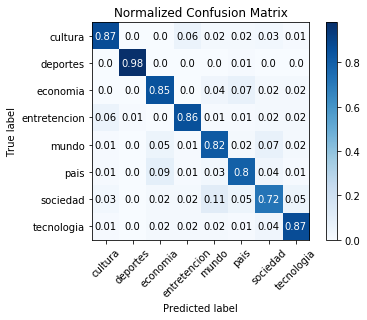

## Accuracy in test: 87.1053513106105 

In [9]:
#X_test = X_test.todense().p'

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


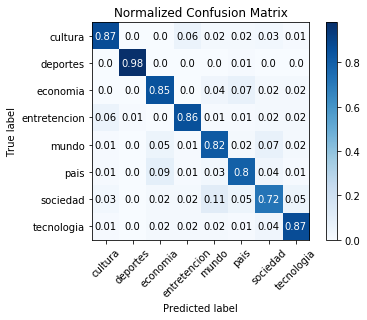

## Accuracy in test: 87.1053513106105 

In [10]:
#X_test = X_test.todense()

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

### save models

In [20]:

pickle.dump( (path_model,labels), open( path_model + "/info_model.p", "wb" ) )

In [11]:
# def input_fn_evaluate1():
#     dataset = {'x': tf.constant(X_test[0:25000,:].todense() )}    
#     return dataset

# pred_test1 = classifier.predict_classes(input_fn=input_fn_evaluate1)

# def input_fn_evaluate2():
#     dataset = {'x': tf.constant(X_test[25000:,:].todense() )}    
#     return dataset
# pred_test2 = classifier.predict_classes(input_fn=input_fn_evaluate2)


In [12]:
# y_test_hat1 = np.asarray([x.decode('UTF-8') for x in list(pred_test1)])
# y_test_hat2 = np.asarray([x.decode('UTF-8') for x in list(pred_test2)])
# y_test_hat = np.concatenate((y_test_hat1, y_test_hat2), axis=0)

In [13]:

# y_test_hat = y_test_hat.astype(str)


# acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

# skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
# plt.xticks(rotation=45)
# plt.show()

# #print('Accuracy in test: {}'.format(acc))
# display(Markdown('## Accuracy in test: {} '.format(acc*100)))